### Rice Diseases Classification

### Load Data from kaggle

In [0]:
# from google.colab import files
# files.upload()

In [0]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

In [11]:
!unzip rice-diseases-image-dataset.zip

Archive:  rice-diseases-image-dataset.zip
   creating: Labelled/
   creating: Labelled/LeafBlast/
  inflating: Labelled/LeafBlast/IMG_20190419_095029.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095031.jpg  
  inflating: Labelled/LeafBlast/IMG_2973.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095429.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095439.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_095523.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100501.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100509.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100511.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100539.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100544.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100547.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100605.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100614.jpg  
  inflating: Labelled/LeafBlast/IMG_20190419_100616.jpg  
  inflating: Labelled/LeafBlast/IMG_2019041

### import libraries and preprocess data

In [12]:
import torch
from torch import nn, optim
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline


# check if cuda is available

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print('CUDA is available.  Training on GPU ...')
else:
    print('CUDA is not available!  Training on CPU ...')

CUDA is available.  Training on GPU ...


In [0]:
data_dir = './Labelled'

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224 + 32),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets=dict()
image_datasets['train']=datasets.ImageFolder(data_dir,transform=data_transforms['train'])
image_datasets['valid']=datasets.ImageFolder(data_dir,transform=data_transforms['valid'])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# obtain training indices to use for validation
num_train = len(image_datasets['train'])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['valid'] = valid_loader
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}


# specify class names
class_names = image_datasets['train'].classes

In [40]:
print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


### Visualize the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

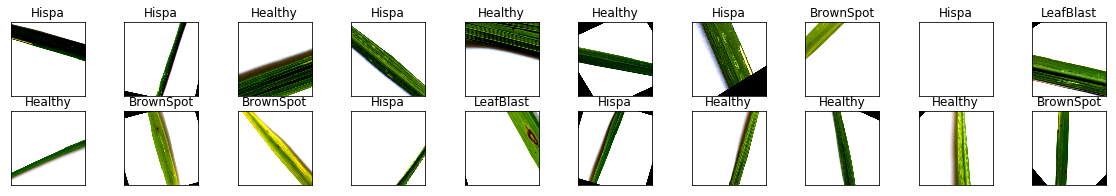

In [41]:
# helper function to un-normalize and display image
def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert from tensor image

# obtain one batch of training images

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in batch with their labels
fig = plt.figure(figsize=(20, 3))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]])


### Build and train the Classifier

Now the data is ready, we will now build the classifier, we will use pretrained models to achieve high accuracy with less time on training

In [0]:
# download the pretrained model

model = models.resnet152(pretrained=True)

# freeze all pretrained model parameters
for param in model.parameters():
    param.requires_grad = False

In [0]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 4)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# replace the pretrained model with our classifier
model.fc = classifier

In [0]:
#train model
def train_model(model, criteria, optimizer, scheduler, num_epochs=25, device='cuda'):

    model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model
  
  

In [45]:
from torch.optim import lr_scheduler
import time
import copy


criteria = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ft = train_model(model, criteria, optimizer, sched, epochs, device)

Epoch 0/19
----------
train Loss: 0.9394 Acc: 0.3934
valid Loss: 0.1914 Acc: 0.1237

Epoch 1/19
----------
train Loss: 0.8467 Acc: 0.4456
valid Loss: 0.1871 Acc: 0.1267

Epoch 2/19
----------
train Loss: 0.7950 Acc: 0.4680
valid Loss: 0.1839 Acc: 0.1213

Epoch 3/19
----------
train Loss: 0.7577 Acc: 0.4900
valid Loss: 0.1717 Acc: 0.1341

Epoch 4/19
----------
train Loss: 0.7431 Acc: 0.5007
valid Loss: 0.1671 Acc: 0.1371

Epoch 5/19
----------
train Loss: 0.7523 Acc: 0.4927
valid Loss: 0.1675 Acc: 0.1347

Epoch 6/19
----------
train Loss: 0.7390 Acc: 0.4987
valid Loss: 0.1698 Acc: 0.1317

Epoch 7/19
----------
train Loss: 0.7372 Acc: 0.4987
valid Loss: 0.1681 Acc: 0.1335

Epoch 8/19
----------
train Loss: 0.7313 Acc: 0.5022
valid Loss: 0.1677 Acc: 0.1338

Epoch 9/19
----------
train Loss: 0.7510 Acc: 0.4930
valid Loss: 0.1679 Acc: 0.1344

Epoch 10/19
----------
train Loss: 0.7317 Acc: 0.5031
valid Loss: 0.1687 Acc: 0.1335

Epoch 11/19
----------
train Loss: 0.7300 Acc: 0.4975
valid Loss

In [0]:
#Save the checkpoint 
model_file_name = 'classifier.pth'
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'resnet152',
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx},
model_file_name)

In [54]:
# save to drive
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'resnet152_second.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
